In [1]:
# STEP 1 - Prepare the Data
import pandas as pd
from sklearn.model_selection import train_test_split

df_fi = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)
df_fi.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# Spilt the data into different classifications - required for pre processing to train the pipeline for Random Forest Model - See step 2
categorical_columns = ["WorkClass", "Education", "EducationNum", "MaritalStatus", "Occupation", "Relationship", "Race", "Gender", "NativeCountry"]
numerical_columns = ["Age", "fnlwgt", "CapitalGain", "CapitalLoss", "HoursPerWeek"]

train_cols = categorical_columns + numerical_columns
label = df_fi.columns[-1]
X = df_fi[train_cols]
y = df_fi[label].apply(lambda x: 0 if x == " <=50K" else 1) #Where income <=50K, set to 0, else set it to 1

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [2]:
# STEP 2 - Pre process the data, categorize some of the columns - e.g. gender, then train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['WorkClass', 'Education',
                                                   'EducationNum',
                                                   'MaritalStatus',
                                                   'Occupation', 'Relationship',
                                                   'Race', 'Gender',
                                                   'NativeCountry']),
                                                 ('num', SimpleImputer(),
                                                  ['Age', 'fnlwgt',
                                                   'CapitalGain', 'CapitalLoss',
                                                   'HoursPerWeek'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [3]:
# STEP 3 - Check accuracy, performance of model, using both train and test data. Train should be 1.000, and test less than 1.000
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.859


In [4]:
# STEP 4 - Tree’s Feature Importance from Mean Decrease in Impurity (MDI).
# The impurity-based feature importance ranks the numerical features to be the most important features, thus why you see fnlwgt ranked high in the graph produced in STEP 5
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

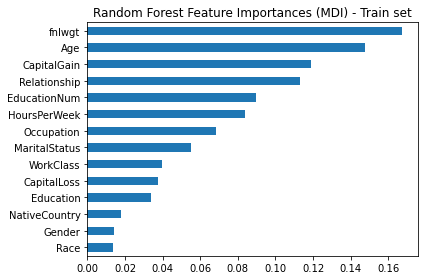

In [6]:
# STEP 5 - Plot the graph.
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI) - Train set")
ax.figure.tight_layout()

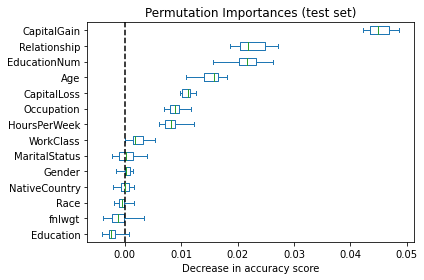

In [7]:
# STEP 6 - Instead of MDI, lets use permutation importance, and use it with the test data
from sklearn.inspection import permutation_importance

result_test = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)
ax = importances_test.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

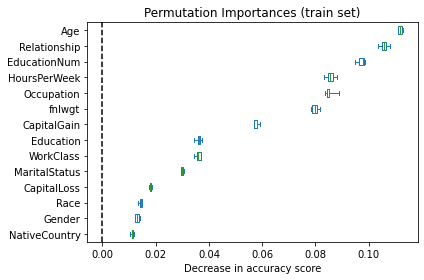

In [8]:
# STEP 7 - Instead of MDI, lets use permutation importance, and use it with the train data
result_train = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)
ax = importances_train.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [9]:
# STEP 8 - reduce overfitting with sample leaf param
rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['WorkClass', 'Education',
                                                   'EducationNum',
                                                   'MaritalStatus',
                                                   'Occupation', 'Relationship',
                                                   'Race', 'Gender',
                                                   'NativeCountry']),
                                                 ('num', SimpleImputer(),
                                                  ['Age', 'fnlwgt',
                                                   'CapitalGain', 'CapitalLoss',
                                                   'HoursPerWeek'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=20, random_state=42))])

In [10]:
# STEP 9 - Check accuracy, performance of model, using both train and test data. Train and test performance should be closer after previous step
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}") # Note that socres between test and train are now cloder - overfitting reduced

RF train accuracy: 0.868
RF test accuracy: 0.863


In [11]:
# STEP 10  - Now check the permutation importance with the newly trained model from step 8 
train_result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

In [12]:
# STEP 11 - Continued from previous step
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

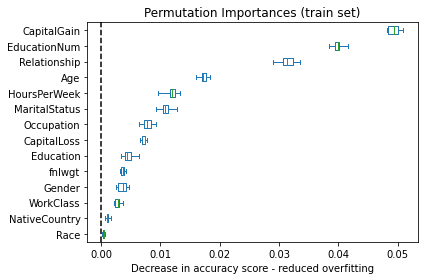

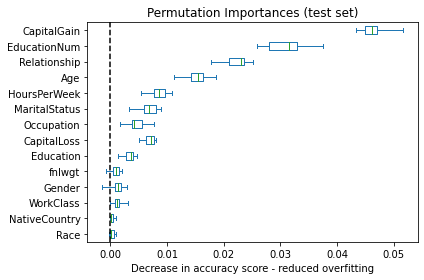

In [13]:
# STEP 12 - Plot the features for both test and train
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score - reduced overfitting")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

In [2]:
# STEP 13 - Build a Glassbox Model - EBM
from interpret.glassbox import ExplainableBoostingClassifier

ebm_fi = ExplainableBoostingClassifier(random_state=seed, n_jobs=-1)
ebm_fi.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['WorkClass', 'Education',
                                             'EducationNum', 'MaritalStatus',
                                             'Occupation', 'Relationship',
                                             'Race', 'Gender', 'NativeCountry',
                                             'Age', 'fnlwgt', 'CapitalGain',
                                             'CapitalLoss', 'HoursPerWeek',
                                             'Relationship x HoursPerWeek',
                                             'Relationship x Age',
                                             'EducationNum x Occupation',
                                             'MaritalStatus x HoursPerWeek',
                                             'Occupation x Relationship',
                                             'Occ...
                              feature_types=['categorical', 'categorical',
                                             'continuous', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction'],
                              n_jobs=-1, random_state=1)

In [15]:
# STEP 14 - Check the performance on this model
ebm_fi.score(X_test, y_test)

0.8702594810379242

In [16]:
# STEP 15 - Determine features importance for the EBM Model - Using the Test Data
    r = permutation_importance( , X_test, y_test,
                            n_repeats=30, #sets the number of times a feature is randomly shuffled
                            random_state=0)

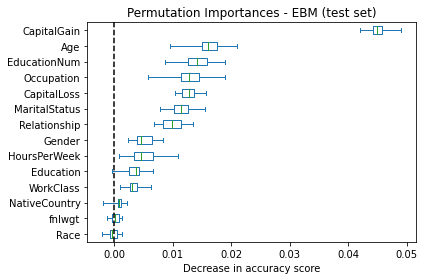

In [17]:
# STEP 16 - Plot the features score from EBM after sorting them in order
sorted_importances_idx_ebm = r.importances_mean.argsort()
importances_ebm = pd.DataFrame(
    r.importances[sorted_importances_idx_ebm].T,
    columns=X.columns[sorted_importances_idx_ebm],
)
ax = importances_ebm.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances - EBM (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

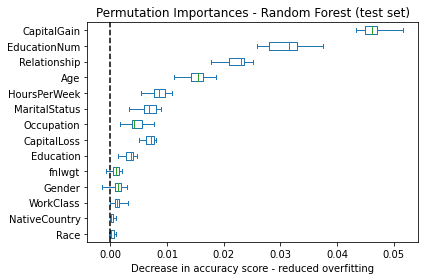

In [18]:
# STEP 17 - Plot the Features for Random Forest, reduced overfitting, for the test data, for comparison purposes with the EBM
ax = test_importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances - Random Forest (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score - reduced overfitting")
ax.figure.tight_layout()

In [19]:
# STEP 18 - Print out the results for EBM, but looking at mean scores for the highest scoring features
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_fi.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

CapitalLoss0.045 +/- 0.001
Gender  0.016 +/- 0.002
fnlwgt  0.014 +/- 0.002
EducationNum0.013 +/- 0.002
HoursPerWeek0.013 +/- 0.001
Education0.012 +/- 0.002
MaritalStatus0.010 +/- 0.002
Relationship0.005 +/- 0.002
NativeCountry0.005 +/- 0.002
WorkClass0.004 +/- 0.002
Age     0.003 +/- 0.001


In [20]:
# STEP 19 - Print out the results for Random Forest, but looking at mean scores for the highest scoring features
# Note that results from step 18 and 19 are different from what you see in the plots.
# Not sure why, but the plots would appear more correct based on understanding of the data.
for i in test_results.importances_mean.argsort()[::-1]:
    if test_results.importances_mean[i] - 2 * test_results.importances_std[i] > 0:
        print(f"{df_fi.columns[i]:<8}"
        f"{test_results.importances_mean[i]:.3f}"
        f" +/- {test_results.importances_std[i]:.3f}")

CapitalLoss0.046 +/- 0.002
fnlwgt  0.031 +/- 0.004
MaritalStatus0.022 +/- 0.002
Gender  0.015 +/- 0.002
NativeCountry0.009 +/- 0.002
HoursPerWeek0.007 +/- 0.001
Education0.007 +/- 0.002
EducationNum0.005 +/- 0.002
WorkClass0.003 +/- 0.001


In [3]:
# STEP 20 - Get a global explain on the EBM and display it for comparison to see if features are matching from Steps 16 and 18.
from interpret import show

ebm_global_fi = ebm_fi.explain_global(name='EBM')
show(ebm_global_fi)

C:\Users\KOBrien\AppData\Roaming\Python\Python310\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\KOBrien\AppData\Roaming\Python\Python310\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\KOBrien\AppData\Roaming\Python\Python310\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7001/2386039303920/ -->

In [7]:
# List each features importance in EBM - option instead of looking at a graph, like in the previous step. Same results but just printed out, instead of shown in a graph
for f_name, importance in zip(ebm_fi.feature_names, ebm_fi.feature_importances_):
    print(f"{f_name}: {importance}")

WorkClass: 0.13907573360684167
Education: 0.22444548047732868
EducationNum: 0.34700998684126466
MaritalStatus: 0.6436098779310904
Occupation: 0.38948719433371737
Relationship: 0.5042451134638052
Race: 0.05920508400506391
Gender: 0.35737094692892885
NativeCountry: 0.08378801709997336
Age: 0.6800673374690709
fnlwgt: 0.12633985307719142
CapitalGain: 0.5646756650417806
CapitalLoss: 0.14701506806196957
HoursPerWeek: 0.31821763061191377
Relationship x HoursPerWeek: 0.04807590281909756
Relationship x Age: 0.027879631049510075
EducationNum x Occupation: 0.019091989328774074
MaritalStatus x HoursPerWeek: 0.06722046126075175
Occupation x Relationship: 0.02655199601111298
Occupation x HoursPerWeek: 0.025710436601576247
Age x fnlwgt: 0.02526323587762637
fnlwgt x HoursPerWeek: 0.029218944044197625
EducationNum x HoursPerWeek: 0.02181281247931268
Relationship x CapitalLoss: 0.012694426378340841


In [6]:
#mdi_importances = pd.Series(
 #   rf[-1].feature_importances_, index=feature_names
#).sort_values(ascending=True)

print(mdi_importances)

Race             0.013582
Gender           0.014170
NativeCountry    0.017600
Education        0.034019
CapitalLoss      0.037376
WorkClass        0.039860
MaritalStatus    0.054913
Occupation       0.068313
HoursPerWeek     0.083799
EducationNum     0.089718
Relationship     0.112913
CapitalGain      0.118848
Age              0.147621
fnlwgt           0.167269
dtype: float64


In [27]:
'''result_test = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)
ax = importances_test.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()'''

print(result_test)
print(importances_test)
print(sorted_importances_idx_test)
print(importances_test.mean().sort_values(ascending=False))
print(importances_test.mean().sort_values(ascending=False).head(4))
test_df = importances_test.mean().sort_values(ascending=False).head(4)
print(test_df.to_csv())
#df.iloc[:, : 50]

{'importances_mean': array([ 2.11883924e-03, -2.19560878e-03,  2.15108245e-02,  3.83847689e-04,
        8.88991248e-03,  2.24013511e-02, -5.22032857e-04,  2.91724244e-04,
       -3.07078151e-05,  1.51850146e-02, -7.83049286e-04,  4.53247351e-02,
        1.10087517e-02,  8.33717181e-03]), 'importances_std': array([0.00155643, 0.00139383, 0.00293372, 0.00177767, 0.00137235,
       0.00277855, 0.00093445, 0.00085335, 0.001018  , 0.00223498,
       0.00228402, 0.0021992 , 0.0008605 , 0.0017641 ]), 'importances': array([[ 0.00199601,  0.00138185,  0.00537387,  0.00153539,  0.00261016,
         0.00337786,  0.        ,  0.        ,  0.00153539,  0.00337786],
       [-0.00245663, -0.00168893, -0.0027637 , -0.0027637 , -0.00399202,
        -0.00199601, -0.00399202, -0.00046062,  0.0007677 , -0.00261016],
       [ 0.02164901,  0.01566099,  0.01811761,  0.02226317,  0.01980654,
         0.02180255,  0.02349148,  0.02134193,  0.02471979,  0.02625518],
       [ 0.00399202,  0.00107477,  0.00107477

In [36]:
print(test_df.to_csv())

,0
CapitalGain,0.04532473514509444
Relationship,0.022401351143866165
EducationNum,0.0215108245048365
Age,0.01518501458621221



In [38]:
pd_json = test_df.to_csv()
#rj = pd_json.read_csv()
print(pd_json.read_csv())

AttributeError: 'str' object has no attribute 'read_csv'